In [1]:
from multi_nutrient_model import ref_parameters, perturbation_dynamics, perturbation_steady_state, I0, PARAMETER_NAMES, fluxes
import numpy as np


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Change font size and style
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', ],
})

In [3]:
data = pd.read_csv('data/NHANES Demo Anthro Glc Ins.csv', index_col=0)

In [4]:
# Map important variables to human readable names
data.rename(columns={
    'sddsrvyr': 'Survey year',
    'lbxglu': 'Glucose (mg/dL)',
    'lbxin': 'Insulin (uU/mL)',
    'bmxwaist': 'Waist circumference (cm)',
    'bmxht': 'Height (cm)',
    'bmxwt': 'Weight (kg)',
    'bmxbmi': 'BMI (kg/m²)',
    'riagendr': 'Gender',
    'ridageyr': 'Age (years)',
    'sialang':'Pregnancy status at exam',
    'diq050': 'Takeing insulin',
    'wtsaf2yr':'Fasting Subsample 2 Year MEC Weight'
    }
    , inplace=True
)

In [5]:
age_cuttoff = 60

In [6]:
# Cange sex to human readable names
mapping = {1: 'M', 2: 'F'}
data['Gender'] = data['Gender'].map(mapping)

# Chnage taking insulin
# 1 = yes, 2 = no
mapping = {1: 'Yes', 2: 'No'}
data['Takeing insulin'] = data['Takeing insulin'].map(mapping) 

# Drop all rows with missing in gender, waist circumference, height, glucose, and insulin
data = data.dropna(subset=['Gender', 'Waist circumference (cm)', 'Height (cm)', 'Glucose (mg/dL)', 'Insulin (uU/mL)'])

# FIlter for some data quality issues
data = data[(data['Glucose (mg/dL)'] > 40) ]
data = data[(data['Insulin (uU/mL)'] > 1) ]

# Only keep adults 20 - 60 years old
data = data[(data['Age (years)'] >= 20) & (data['Age (years)'] <= age_cuttoff)]

# Exclude taking insulin
data = data[data['Takeing insulin'] == 'No']

# Make sure participants where in a controlled fasting cohort data['phafsthr'] > 6
data = data[data['phafsthr'] > 6]

In [7]:
def body_fat_percentage_BMI(BMI, age, gender):
    """
    Calculate body fat percentage from BMI
    :param BMI: Body Mass Index
    :param age: Age in years
    :param: Sex m or f 
    :return: Body fat percentage

    """ 

    if gender.lower() == 'm':
        BFP = 1.20 * BMI + 0.23 * age - 16.2
    elif gender.lower() == 'f':
        BFP = 1.20 * BMI + 0.23 * age - 5.4
    else:
        raise ValueError('Gender must be "m" or "f"')
    return BFP

In [8]:
def body_fat_percentage_waist(height, waist, gender):
    """
    Calculate body fat percentage based on waist circumference and height.
    Parameters
    ----------
    height : float   
        Height in cm
    waist : float
        Waist circumference in cm  
    
    """
    if gender.lower() == 'm':
        return 64 - (20 * (height / waist))

    elif gender.lower() == 'f':
        return 76 - (20 * (height / waist))
    else:
        raise ValueError('Gender must be male (m) or female (f)')


In [9]:
# Compute body fat percentage
data['body_fat_percentage'] = data.apply(
    lambda row: body_fat_percentage_waist(row['Height (cm)'], row['Waist circumference (cm)'], row['Gender']), axis=1
)

In [10]:
# Compute body fat percentage
data['body_fat_percentage_BMI'] = data.apply(
    lambda row: body_fat_percentage_BMI(row['BMI (kg/m²)'], row['Age (years)'], row['Gender']), axis=1
)

In [11]:
data['body_fat_mass'] = data['body_fat_percentage'] * data['Weight (kg)'] / 100

In [12]:
# Drop na values in body fat mass
data = data.dropna(subset=['body_fat_mass'])

In [13]:
 # Compute HOMA-IR
data['HOMA-IR'] = (data['Insulin (uU/mL)'] * data['Glucose (mg/dL)']) / 405
# Compute HOMA-B
data['HOMA-B'] = (360 * data['Insulin (uU/mL)']) / (data['Glucose (mg/dL)'] - 63)

# Inuslin glucose ratio 
data['Insulin/Glucose'] = data['Insulin (uU/mL)'] / data['Glucose (mg/dL)'] * 100/7.5 

In [14]:
# Waist to height ratio
data['waist_height_ratio'] = data['Waist circumference (cm)'] / data['Height (cm)']

In [15]:
# Exldue nagitve HOMA-B values
data = data[data['HOMA-B'] >= 0]
# And HOMA-B values greater than 1000
data = data[data['HOMA-B'] < 1000]

In [16]:
# Add columns with Gender that has the full description Male, Female
data['Gender_full'] = data['Gender'].map({ 'M': 'Male' , 'F': 'Female',})

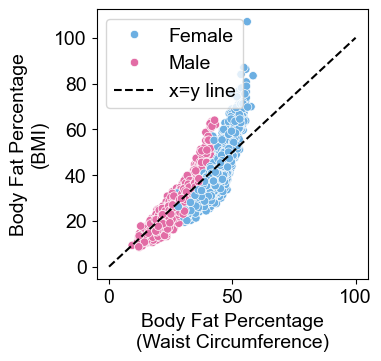

In [17]:
ax, f = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(data=data, 
                x='body_fat_percentage',
                y='body_fat_percentage_BMI',
                hue='Gender_full',
                palette=["#6cafe2","#e26ca5",],
)

# x=y line
x = np.linspace(0, 100, 100)
y = x
plt.plot(x, y, color='black', linestyle='--', label='x=y line')
plt.xlabel('Body Fat Percentage\n(Waist Circumference)')
plt.ylabel('Body Fat Percentage\n(BMI)')
plt.legend()

In [18]:
# Count number of participants in each gender
data.groupby('Gender_full').count()['seqn']

Gender_full
Female    3933
Male      3625
Name: seqn, dtype: int64

In [19]:

KI_F = 0.2
p_fited = ref_parameters(  KI_F = KI_F,  )


In [20]:
# Adiposity range 
A= np.linspace(1.0, 3, 100)  

k = p_fited[PARAMETER_NAMES.index('k')]
C = p_fited[PARAMETER_NAMES.index('C')]
Imax = p_fited[PARAMETER_NAMES.index('Imax')]

I0 = abs(1.0)**k / (abs(1.0)**k + C**k) * Imax

results = [perturbation_steady_state(a, p=p_fited) for a in A]
fluxes = [fluxes(r,a,p_fited)for r,a in zip(results, A)]

G = np.array([r[1] for r in results]) * 85
I = np.array([r[-1] for r in results]) * 5.0 / I0

HOMA_IR = (G * I) / 405
HOMA_B = (360 * I ) / ( G - 63)

HFP_MEN = 0.18
L_M = (1.0 - HFP_MEN) / (HFP_MEN)
FP_M = A/(A+L_M) * 100 

HFP_WOMEN = 0.30
L_W = (1.0 - HFP_WOMEN) / (HFP_WOMEN)
FP_W = A/(A+L_W) * 100

AS = A * 15  # in kg

In [21]:
from sklearn.metrics import r2_score

# Split data by gender
male_data = data[data['Gender_full'] == 'Male']
female_data = data[data['Gender_full'] == 'Female']

male_data['model_glucose'] = np.interp(male_data['body_fat_percentage'], FP_M, G,)
female_data['model_glucose'] = np.interp(female_data['body_fat_percentage'], FP_W, G,)

male_data['model_insulin'] = np.interp(male_data['body_fat_percentage'] , FP_M, I)
female_data['model_insulin'] = np.interp(female_data['body_fat_percentage'], FP_W, I)

# Recompute HOMA-IR and HOMA-B
male_data['model_homa'] = (male_data['model_insulin'] * male_data['model_glucose']) / 405
male_data['model_homa_b'] = (360 * male_data['model_insulin']) / (male_data['model_glucose'] - 63)

female_data['model_homa'] = (female_data['model_insulin'] * female_data['model_glucose']) / 405
female_data['model_homa_b'] = (360 * female_data['model_insulin']) / (female_data['model_glucose'] - 63)


In [22]:
# Recombines male and female data for plotting
data = pd.concat([male_data, female_data], ignore_index=True)

In [23]:
# Compute deciles (10 quantiles) of body fat percentage per gender
data['body_fat_percentage_decile'] = data.groupby('Gender_full')['body_fat_percentage'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

# Compute the median of body fat percentage for each decile and gender
bin_median_gender = data.groupby(['Gender_full', 'body_fat_percentage_decile'])['body_fat_percentage'].median()
data['body_fat_percentage_bin'] = data.set_index(['Gender_full', 'body_fat_percentage_decile']).index.map(bin_median_gender)

In [24]:
# Compute deciles (10 quantiles) of body fat percentage per gender
data['body_fat_mass_decile'] = data.groupby('Gender_full')['body_fat_mass'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

# Compute the median of body fat percentage for each decile and gender
bin_median_gender = data.groupby(['Gender_full', 'body_fat_mass_decile'])['body_fat_mass'].median()
data['body_fat_mass_bin'] = data.set_index(['Gender_full', 'body_fat_mass_decile']).index.map(bin_median_gender)

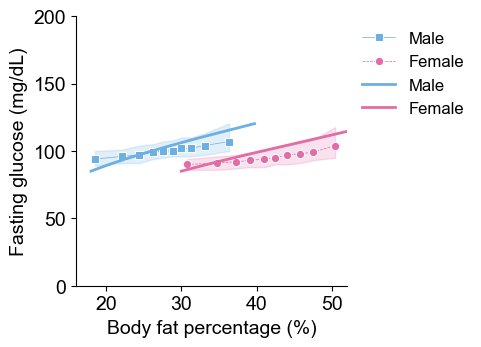

In [25]:
# Alternative plot using line plot and bins 
plt.figure(figsize=(3.5, 3.5))
sns.lineplot(data=data, 
                x='body_fat_percentage_bin',
                y='Glucose (mg/dL)',
                hue='Gender_full',
                style='Gender_full',
                markers=['s','o'],
                marker='o',
                palette=["#6cafe2","#e26ca5",],
                hue_order=['Male','Female'],
                errorbar=('pi',50),
                estimator='median',
                linewidth=0.5,
)

plt.plot(FP_M, G, color="#6cafe2", label='Male', linewidth=2)
plt.plot(FP_W, G, color="#e26ca5", label='Female', linewidth=2)

plt.ylabel('Fasting glucose (mg/dL)')
plt.xlabel('Body fat percentage (%)')

plt.ylim(0, 200)
plt.xlim(16, 52)

# Put legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, frameon=False)

sns.despine()

# Save the figure
plt.savefig('./output/glucose_vs_fat_mass_binned.svg', bbox_inches='tight')

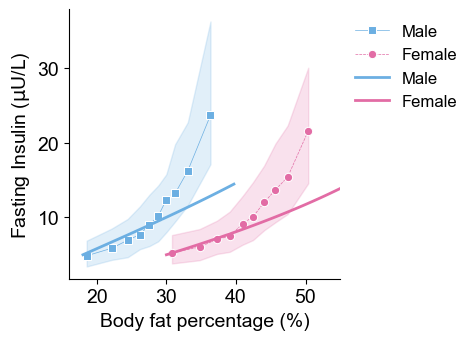

In [26]:
# Alternative plot using line plot and bins 
plt.figure(figsize=(3.5, 3.5))
sns.lineplot(data=data, 
                x='body_fat_percentage_bin',
                y='Insulin (uU/mL)',
                hue='Gender_full',
                style='Gender_full',
                markers=['s','o'],
                marker='o',
                palette=["#6cafe2","#e26ca5",],
                hue_order=['Male','Female'],
                errorbar=('pi',50),
                estimator='median',
                linewidth=0.5,

)

plt.plot(FP_M, I, color="#6cafe2", label='Male', linewidth=2)
plt.plot(FP_W, I, color="#e26ca5", label='Female', linewidth=2)


plt.ylabel('Fasting Insulin ($\mathrm{\mu}$U/L)')
plt.xlabel('Body fat percentage (%)')

#plt.ylim(0, 200)
plt.xlim(16, 55)

# Put legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, frameon=False)

sns.despine()

# Save the figure
plt.savefig('./output/insulin_vs_fat_mass_binned.svg', bbox_inches='tight')

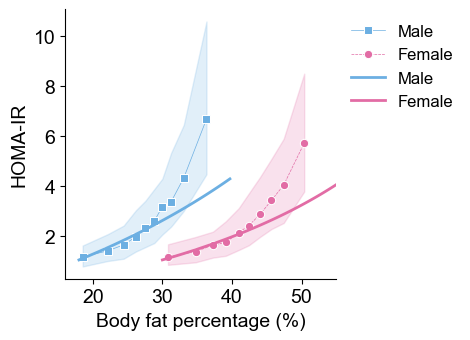

In [27]:
# Alternative plot using line plot and bins 
plt.figure(figsize=(3.5, 3.5))
sns.lineplot(data=data, 
                x='body_fat_percentage_bin',
                y='HOMA-IR',
                hue='Gender_full',
                style='Gender_full',
                markers=['s','o'],
                marker='o',
                palette=["#6cafe2","#e26ca5",],
                hue_order=['Male','Female'],
                errorbar=('pi',50),
                estimator='median',
                linewidth=0.5,

)

plt.plot(FP_M, HOMA_IR, color="#6cafe2", label='Male', linewidth=2)
plt.plot(FP_W, HOMA_IR, color="#e26ca5", label='Female', linewidth=2)


plt.xlabel('Body fat percentage (%)')
plt.ylabel('HOMA-IR')

#plt.ylim(0, 5)
plt.xlim(16, 55)

# Put legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, frameon=False)

sns.despine()

# Save the figure
plt.savefig('./output/homa_ir_vs_fat_mass_binned.svg', bbox_inches='tight')

Text(0.5, 0, 'Body fat mass (kg)')

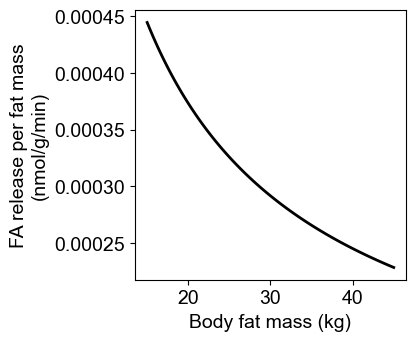

In [28]:
# Plot fatty acids release vs body fat mass 
plt.figure(figsize=(3.5, 3.5))
vA = np.array([v[8] for v in fluxes])
plt.plot(AS, vA / AS  , color="#000000", label='Model', linewidth=2) 

plt.ylabel('FA release per fat mass\n(nmol/g/min)')
plt.xlabel('Body fat mass (kg)')